# **Pattern Recognition Course (Fall 2024) - Assignment #2**

**Due date**: 30th Aban 1403

**Objective**: Applying PCA and FLD techniques to the Iris dataset for dimensionality reduction and
classification.

**Dataset**: The Iris dataset contains 150 samples of iris flowers, categorized into 3 classes (setosa,
versicolor, virginica). Each sample has 4 features: sepal length, sepal width, petal length, and petal
width.


In [ ]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import math
from typing import Dict, TypeVar

# Stage 1 : Data Acquisition


> **Q2**: Visualize the dataset.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   label         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


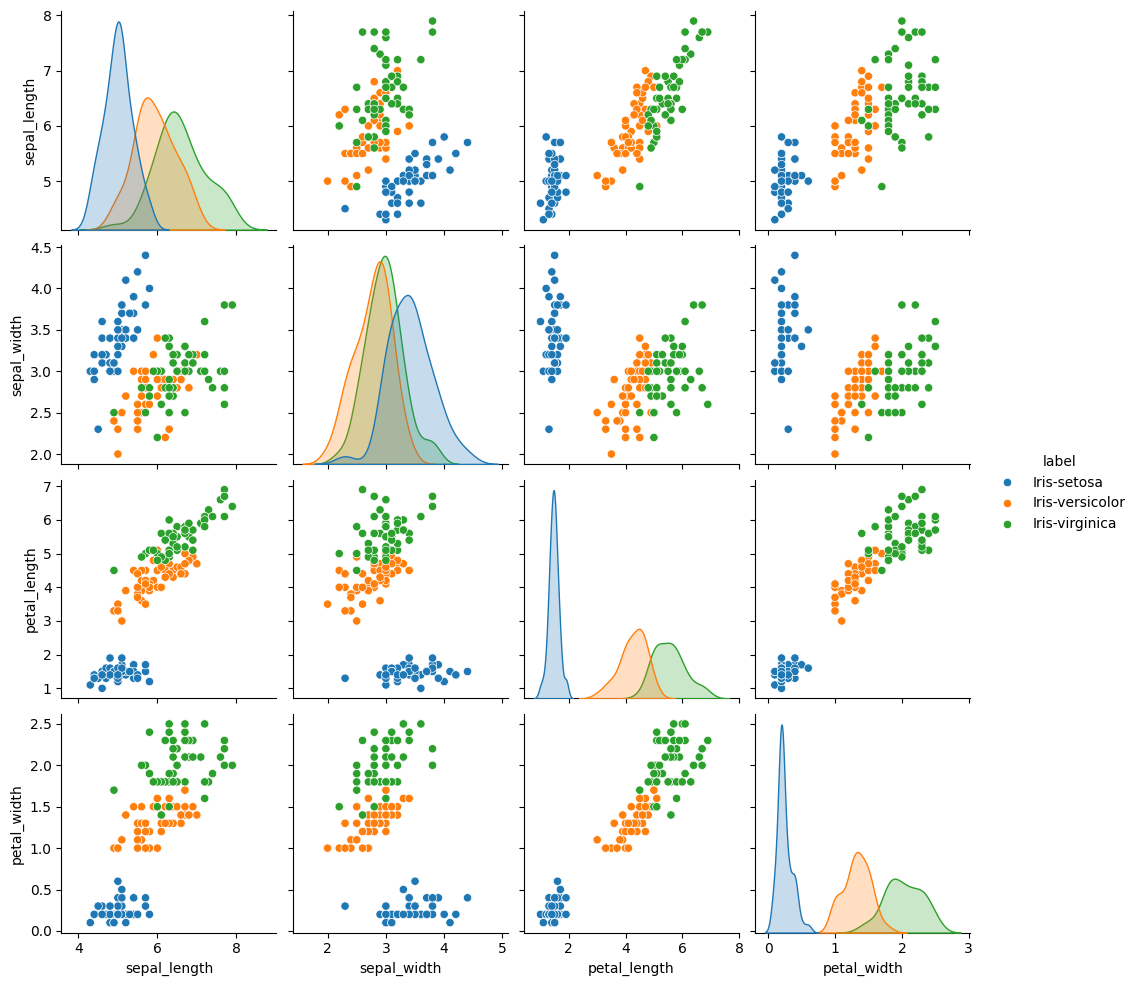

In [59]:
feat_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "label"]
df = pd.read_csv(
    "iris.csv",
    sep=",",
    names=feat_names,
)

df.info()

sns.pairplot(df, hue="label")
plt.show()

# Stage 2: Data Preprocessing


> **Q3** : Normalize the dataset.

**Why?** PCA is quite sensitive regarding the variances of the initial variables. That is, if there are large differences between the ranges of initial variables, those variables with larger ranges will dominate over those with small ranges

**Min Max Scaling** also know as normalization, Transforms features to a specific range: Typically, this range is [0, 1].

- Preserves the original shape of the distribution.
- Sensitive to outliers: Outliers can significantly affect the scaling.

**Standardization** (Z-score normalization): Transforms features to have zero mean and unit standard deviation.

- Changes the shape of the distribution.
- Less sensitive to outliers compared to min-max scaling.


In [ ]:
def min_max_scaler(feat_col: pd.Series) -> float:
    min_val = feat_col.min()
    max_val = feat_col.max()

    numerator_term = feat_col - min_val
    denominator_term = max_val - min_val

    return numerator_term / denominator_term


def standardize(feat_col: pd.Series) -> float:
    mean = feat_col.mean()
    std = feat_col.std()

    return (feat_col - mean) / std


df_normalized = df.copy(deep=True)
# df_normalized[df.columns[:4]] = df[df.columns[:4]].apply(min_max_scaler)
df_normalized[df.columns[:4]] = df[df.columns[:4]].apply(standardize)

# Stage 3 : Dimensionality Reduction


## PCA


> **Q4.1:** Compute the Covariance matrix

**why?** Because sometimes, variables are highly correlated in such a way that they contain redundant information. So, in order to identify these correlations, we compute the covariance matrix.

**How to interpret?** The sign of the covariance that matters:

- If (+) then: the two variables increase or decrease together (correlated)
- If (-) then: one increases when the other decreases (Inversely correlated)


In [63]:
cov_df = df_normalized[df.columns[:4]].cov()
print(cov_df)

              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000


> **Q4.2:** Plot the Eigenvalues of the Covariance matrix in descending order

The **eigen decomposition** is performed on the covariance matrix to obtain the eigenvalues and eigenvectors.

1.  Eigenvalues represent coefficients attached to eigenvectors, which give the amount of variance carried in each Principal Component.
2.  Eigenvectors represent the directions or axes of maximum variance in the data.

**How to visualize?** In order to compute the percentage of variance (information) accounted for by each component, we divide the eigenvalue of each component by the sum of eigenvalues and plot the data on a scree plot.


>>> Eigen values and Eigen Vectors:
[(2.9108180837520563, [0.5223716204076606, -0.37231836334996876, -0.7210168090620422, 0.26199558689998087]), (0.9212209307072229, [-0.2633549153139397, -0.9255564941472947, 0.24203287721394112, -0.12413481006268233]), (0.14735327830509587, [0.5812540055976475, -0.02109477684124587, 0.1408922584875416, -0.801154269079924]), (0.02060770723562511, [0.5656110498826492, -0.06541576907892808, 0.6338014033558239, 0.5235462716041909])]


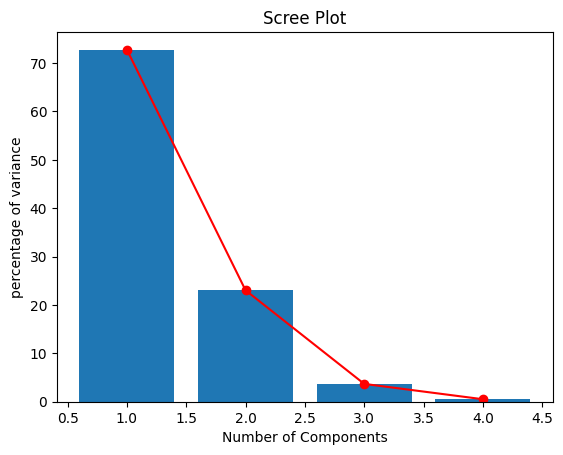

In [ ]:
# Convert to NumPy array
cov_arr = cov_df.values
eigenvalues, eigenvectors = np.linalg.eig(cov_arr)

eig_list = [
    (eigval, eigvect)
    for eigval, eigvect in zip(eigenvalues.tolist(), eigenvectors.tolist())
]
sorted_eiglist_desc = sorted(eig_list, key=lambda x: x[0], reverse=True)
print(">>> Eigen values and Eigen Vectors:")
print(sorted_eiglist_desc)

sum_eigenvalues = eigenvalues.sum()
var_percentage = [(e[0] / sum_eigenvalues) * 100 for e in sorted_eiglist_desc]

pc_num = np.arange(1, len(eigenvalues) + 1)
plt.bar(pc_num, var_percentage)
y_centers = pc_num / 2  # the center of each bar
plt.plot(pc_num, var_percentage, marker="o", linestyle="-", color="red")
plt.xlabel("Number of Components")
plt.ylabel("percentage of variance")
plt.title("Scree Plot")
plt.show()

> **Q5:** Choose an appropriate number of features based on the Eigenvalue plot

**Select the principal components**: The eigenvectors associated with the highest eigenvalues are selected as the principal components.

_These components capture the most significant patterns or variations in the data._


**Q6**: Project the data into the new subspace

**Project the data onto the principal components**: The original data is projected onto the selected principal components to obtain the transformed lower-dimensional representation. Each data point is represented by its coordinates along the principal components.


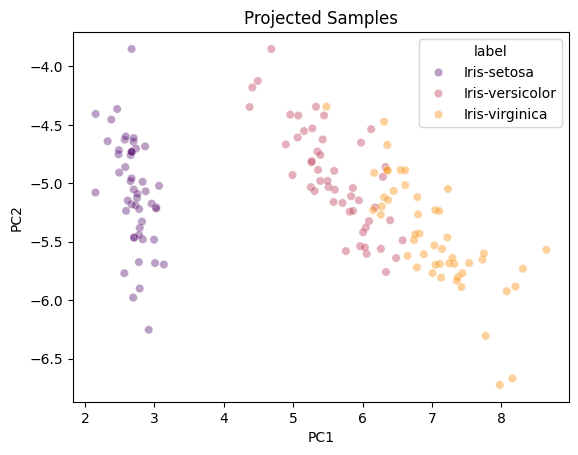

In [ ]:
selected_pc = 2
projection_matrix = np.array([e[1] for e in sorted_eiglist_desc])

# apply the transformation to the feature columns, keeping the label column unchanged
projected_arr = np.dot(df.values[:, :4], projection_matrix[:, :selected_pc])
projected_df = pd.DataFrame(
    {
        "PC1": projected_arr[:, 0],
        "PC2": projected_arr[:, 1],
        "label": df["label"],
    }
)

sns.scatterplot(
    x="PC1", y="PC2", hue="label", data=projected_df, palette="inferno", alpha=0.4
)
plt.title("Projected Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

# Stage 4: Model Building


**Q7.1:** Apply a Bayes classifier with a Gaussian parametric estimate of pdfs


In [ ]:
class NBGaussian:
    def __init__(self, inv_cov: np.ndarray, det_cov: int, class_mean: np.ndarray):
        self.inv_cov = inv_cov
        self.det_cov = det_cov
        self.class_mean = class_mean
        self.term_1 = 0.5 * math.log(det_cov, math.e)

    def g(self, sample: np.ndarray) -> float:
        diff = sample - self.class_mean
        term_2 = 0.5 * np.dot(diff.T, np.dot(self.inv_cov, diff))

        return -(self.term_1 + term_2)


class BayesClassifier:
    class_labels = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

    def __init__(self):
        pass

    @staticmethod
    def df_splitter(df: pd.DataFrame, test_frac: float):
        if test_frac >= 1:
            print("Test Ratio must be less than zero")
            return

        test_df = df.sample(frac=test_frac)
        train_df = df.drop(test_df.index)

        return train_df, test_df

    @classmethod
    def train_model(cls, train_df: pd.Series):
        label_discriminator_dict = {}
        for label in cls.class_labels:
            prj_label_df = train_df.query(f"label == '{label}'")
            label_cov = prj_label_df.iloc[:, :2].cov().to_numpy()
            label_mean = prj_label_df.iloc[:, :2].mean().to_numpy()
            label_discriminator = NBGaussian(
                inv_cov=np.linalg.inv(label_cov),
                det_cov=np.linalg.det(label_cov),
                class_mean=label_mean,
            )

            print(f">>> Label : {label} <<<")
            print(
                f"cov : {label_cov}\n mean : {label_mean} \n inv-cov : {label_discriminator.inv_cov} \n det-cov : {label_discriminator.det_cov}\n"
            )

            label_discriminator_dict[label] = label_discriminator

        return label_discriminator_dict

    @staticmethod
    def predictor(sample: pd.Series, label_f_dict):
        chances = {}
        for label, label_f in label_f_dict.items():
            g = label_f.g(sample.to_numpy())
            chances[g] = label
        return chances.get(max(chances.keys()))

    @classmethod
    def predict(cls, test_df: pd.DataFrame, label_discriminator_dict):
        """Apply the function to each row and create a new DataFrame

        Args:
            test_df (pd.DataFrame): _description_
            label_discriminator_dict (_type_): _description_

        Returns:
            _type_: _description_
        """
        prediction_df = test_df.iloc[:, :2].apply(
            lambda row: cls.predictor(row, label_discriminator_dict), axis=1
        )
        prediction_df.rename("Result")  # Rename the column
        return prediction_df


train_df, test_df = BayesClassifier.df_splitter(df=projected_df, test_frac=0.3)
label_discriminator_dict = BayesClassifier.train_model(train_df=train_df)
prediction_df = BayesClassifier.predict(
    test_df=test_df, label_discriminator_dict=label_discriminator_dict
)
comparison_df = test_df.iloc[:, 2].compare(prediction_df)


>>> Label : Iris-setosa <<<
cov : [[ 0.05022166 -0.04724272]
 [-0.04724272  0.22927563]]
 mean : [2.6938278025900875 -5.076840519655283] 
 inv-cov : [[24.69916479  5.08931469]
 [ 5.08931469  5.41022658]] 
 det-cov : 0.009282727915506068

>>> Label : Iris-versicolor <<<
cov : [[ 0.27239179 -0.15158946]
 [-0.15158946  0.14462616]]
 mean : [5.590621549596298 -4.908809404027683] 
 inv-cov : [[ 8.81028038  9.23446801]
 [ 9.23446801 16.59345723]] 
 det-cov : 0.016415614112117203

>>> Label : Iris-virginica <<<
cov : [[ 0.53309862 -0.30726702]
 [-0.30726702  0.27895761]]
 mean : [7.082265557808538 -5.475331655999996] 
 inv-cov : [[5.13744508 5.65880749]
 [5.65880749 9.81785326]] 
 det-cov : 0.05429889879197934



# Stage 5: Evaluation


**Q7.2:** report the accuracy


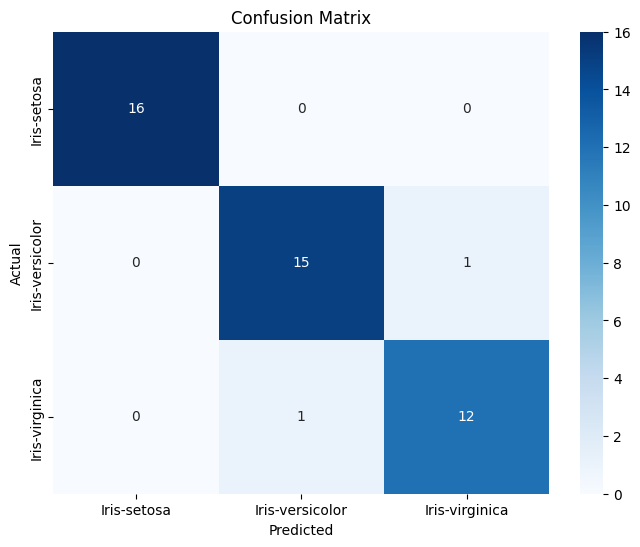

In [ ]:
cm = confusion_matrix(
    test_df.iloc[:, 2], prediction_df, labels=BayesClassifier.class_labels
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=BayesClassifier.class_labels,
    yticklabels=BayesClassifier.class_labels,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()